## CS 6120: Natural Language Processing - Prof. Ahmad Uzair

### Assignment 3: Implementing Skipgram and CBOW Algorithms

In [86]:
## Importing the Libraries
from collections import Counter
import math
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import pandas as pd
import re
import random
from sklearn.decomposition import PCA

## Data Collection

In [6]:
# read the data from text8 file

with open("text8", "r") as f:
    text = f.readline().lower()

In [7]:
len(text)

713069767

## Pre-processing

In [8]:
def clean_tokens(words):
    '''
    Input:
        words: a list of tokens
    Output:
        filtered_words: a processed words list

    '''
    # list to track filtered words
    filtered_words = []
    
    # get stopwords
    stop_words = set(stopwords.words('english'))
    
    for w in words:
        # remove stopwords
        if w not in stop_words:
            filtered_words.append(w)
    
    return filtered_words

In [9]:
# create a frequency dictionary

def frequency_dict(tokens):
    '''
    tokens: list containing all the tokens
    ---
    freq_word: returns a dictionary which keeps the count of the number of documents containing the given word
    '''
    freq_word = {}
    
    for token in tokens:
        if token in freq_word:
            freq_word[token] = freq_word.get(token) + 1
        else:
            freq_word[token] = 1

    return freq_word

In [10]:
# tokenize the dataset and convert to lower case
corpus = text.split()

# clean tokens 
clean_corpus = clean_tokens(corpus)

# len of most frequent words
MAX_LENGTH = 10000

# build vocabulary frequency of first 20000 clean corpus
freq_word = frequency_dict(clean_corpus[:MAX_LENGTH])

In [11]:
freq_word

{'anarchism': 102,
 'originated': 2,
 'term': 19,
 'abuse': 2,
 'first': 32,
 'used': 20,
 'early': 21,
 'working': 8,
 'class': 11,
 'radicals': 1,
 'including': 11,
 'diggers': 2,
 'english': 7,
 'revolution': 12,
 'sans': 1,
 'culottes': 1,
 'french': 7,
 'whilst': 2,
 'still': 6,
 'pejorative': 1,
 'way': 9,
 'describe': 4,
 'act': 3,
 'violent': 6,
 'means': 12,
 'destroy': 2,
 'organization': 4,
 'society': 24,
 'also': 48,
 'taken': 2,
 'positive': 2,
 'label': 5,
 'self': 15,
 'defined': 3,
 'anarchists': 76,
 'word': 7,
 'derived': 1,
 'greek': 5,
 'without': 10,
 'archons': 1,
 'ruler': 6,
 'chief': 1,
 'king': 2,
 'political': 10,
 'philosophy': 10,
 'belief': 5,
 'rulers': 1,
 'unnecessary': 1,
 'abolished': 1,
 'although': 18,
 'differing': 2,
 'interpretations': 5,
 'refers': 2,
 'related': 10,
 'social': 45,
 'movements': 20,
 'advocate': 6,
 'elimination': 1,
 'authoritarian': 16,
 'institutions': 7,
 'particularly': 6,
 'state': 26,
 'anarchy': 16,
 'use': 23,
 'imply'

## Implement CBOW

#### Preparing the data

In [270]:
# convert most common words to a list 
vocabulary = set(freq_word.keys())

# assign an ID to each word
word_to_id = {word: i for i, word in enumerate(vocabulary)}
id_to_word = {i: word for word, i in word_to_id.items()}

VOCAB_SIZE = len(vocabulary)

In [271]:
VOCAB_SIZE

3414

#### Model definition

In [272]:
EMBEDDING_SIZE = 5
CONTEXT_SIZE = 2  # using two words from left and two from right

# initialize random weights
W1 = np.random.rand(VOCAB_SIZE, EMBEDDING_SIZE)
W2 = np.random.rand(EMBEDDING_SIZE, VOCAB_SIZE)

def forward(context_word_ids):
    """
    calculate y_predicated values 
    
    Args:
     context_word_ids: a list of context ids

    Returns: predicted values, hidden layer values
     
    """
    # sum the vectors of the context words
    h = np.mean([W1[id] for id in context_word_ids], axis=0)
    
    # produce output
    u = np.dot(h, W2)
    
    # applying softmax    
    y_pred = np.exp(u) / np.sum(np.exp(u))
    
    return y_pred, h

def cross_entropy_loss(y_pred, target_id):
    """
    calculate cross-entropy loss  for the prediction

    Args:
     y_pred: what our model predicted
     target_id: target_id for the word

    Returns:
     cross-entropy loss for y_predicted
    """
    
    return -np.log(y_pred[target_id])
    
def calculate_error(y_pred):
    """
    calculate error for y predicted values

    Args:
     y_pred: what our model predicted

    Returns:
     updated error for predicted values
    """
    
    e = y_pred
    e[target_id] -= 1
    
    return e

#### Training

In [273]:
LEARNING_RATE = 0.05
EPOCHS = 1000

cbow_losses = []

for epoch in range(EPOCHS):
    total_loss = 0
    
    for i, word in enumerate(clean_corpus[:MAX_LENGTH]):
        # prepare context words
        start = max(0, i - CONTEXT_SIZE)
        end = min(MAX_LENGTH, i + CONTEXT_SIZE + 1)
        context = [clean_corpus[j] for j in range(start, end) if j != i]

        # Skip if we don't have enough context
        if len(context) < 2 * CONTEXT_SIZE:
            continue

        context_ids = [word_to_id[w] for w in context]
        target_id = word_to_id[clean_corpus[i]]
        
        # y_pred: the predicted probabilities P(target | context)
        # prob of all words in the vocabulary being the target word given the context.
        y_pred, h = forward(context_ids)

        # calculate the cross entropy loss
        total_loss += cross_entropy_loss(y_pred, target_id)

        # calculate error
        e = calculate_error(y_pred)

        # calculate gradient of the loss with respect to the weights W2 and gradient descent is also an optimizer function
        dW2 = np.outer(h, e)
        
        # spread the error back to the hidden layer
        EH = np.dot(e, W2.T)
    
        # update weight 1
        for word_id in context_ids:
            # divide by the number of context words
            W1[word_id] -= LEARNING_RATE * EH / len(context_ids)  
        
        # update weight 2
        W2 -= LEARNING_RATE * dW2
    
    # append total loss
    cbow_losses.append(total_loss)

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

Epoch 0, Loss: 77175.37718194048
Epoch 100, Loss: 46489.195230823934
Epoch 200, Loss: 39445.06173052146
Epoch 300, Loss: 35658.49961189576
Epoch 400, Loss: 33114.65012360497
Epoch 500, Loss: 31208.03068475534
Epoch 600, Loss: 29722.342288853724
Epoch 700, Loss: 28516.846928753734
Epoch 800, Loss: 27506.715379772675
Epoch 900, Loss: 26656.719304665607


#### Retrieve Embeddings

In [274]:
cbow_word_embeddings = {word: W1[word_to_id[word]] for word in vocabulary}

In [275]:
cbow_word_embeddings

{'crisis': array([-8.14246186,  7.5306789 ,  2.03725837,  8.27701106, 13.50888258]),
 'distance': array([-6.03676381, -0.41461229, -3.9742692 , 10.7915327 , -7.0091828 ]),
 'isbn': array([ 0.61729856,  0.44949372, -2.91464871, -0.07701559,  3.88445639]),
 'shuns': array([-7.17393391, -2.92851589, -7.85644772, -1.90595222, -0.9038556 ]),
 'owen': array([-4.97882159,  4.80418007, 10.52379655,  2.13038789, -0.79735256]),
 'key': array([ 3.93401315,  2.74807228,  0.66574832,  1.81994567, -4.74810272]),
 'tradition': array([  1.2704    ,  11.88564263, -11.4872681 ,   6.37695791,
         -5.77508806]),
 'well': array([-0.26504863,  2.65593512, -2.72678096, -3.03371693, -0.51363183]),
 'choosing': array([-5.58845526,  1.47616014,  2.08316127,  2.91457245, -3.58055635]),
 'communities': array([ 4.73117968,  2.17092837, -8.69921354,  3.32322319,  1.67266417]),
 'including': array([ 3.80408717, -0.07612533,  3.41862679,  0.44124218,  0.06501883]),
 'climate': array([-4.58230334, -2.14517809,  1

## Implement Skipgram

#### Preparing the data

In [35]:
# convert most common words to a list 
vocabulary = set(freq_word.keys())

# assign an ID to each word
word_to_id = {word: i for i, word in enumerate(vocabulary)}
id_to_word = {i: word for word, i in word_to_id.items()}

VOCAB_SIZE = len(vocabulary)

#### Model Definition

In [36]:
EMBEDDING_SIZE = 5
CONTEXT_SIZE = 2  # using two words from left and two from right
LEARNING_RATE = 0.05
EPOCHS = 1000

# initialize random weights
W1 = np.random.rand(VOCAB_SIZE, EMBEDDING_SIZE)
W2 = np.random.rand(EMBEDDING_SIZE, VOCAB_SIZE)

def get_one_hot_vectors(target_word, context_words):
    """
    converts target word and context words to one hot encoding form
    
    Args:
     target_word: target word
     context_word: a list of context words

    Returns:
     target_word_vector, context_word_vector
    """
    
    # create an array of vocab_size filled with zeros for target and context word vectors
    target_word_vector = np.zeros(VOCAB_SIZE)
    context_word_vector = np.zeros(VOCAB_SIZE)
    
    # get the index of the target_word from word_to_id dictionary
    index = word_to_id.get(target_word) 
    
    # set the index to 1
    target_word_vector[index] = 1
    
    # repeat same steps for context_words
    for word in context_words:
        index = word_to_id.get(word) 
        context_word_vector[index] = 1
        
    return target_word_vector, context_word_vector

def forward(target_word_vector):
    """

    calculate y_predicated values 
    
    Args:
     target_word_vector: a target word vector

    Returns: predicted values, hidden layer values, u
     
    """
    
    # dot product of hidden layer
    h = np.dot(W1.T, target_word_vector)
    
    # produce output
    u = np.dot(h, W2)
    
    # applying softmax    
    y_pred = np.exp(u) / np.sum(np.exp(u))
    
    return y_pred, h, u

def backward(total_error, target_word, target_word_vector, h, learning_rate):
    """

    calculate updated W1, W2 values 
    
    Args:
     total_error: error computed in a given cycle
     target_word: a target word
     target_word_vector: a target word vector
     h: a vector of hidden layer
     learning_rate: given learning rate for updating weight values

    Returns: 
     updated weights, uW1, uW2
     
    """
    
    # apply gradient descent
    dW1 = np.outer(target_word_vector, np.dot(W2, total_error.T))
    dW2 = np.outer(h, total_error)
    
    # apply negative sampling
    uW1, uW2 = apply_negative_sampling(target_word, dW1, dW2)
    
    return uW1, uW2

def calculate_error(y_pred, context_word_vector):
    """

    calculate error for y predicted values

    Args:
     y_pred: what our model predicted
     context_word_vector: vectors of context words

    Returns:
     updated error for predicted values
     
    """
    
    total_error = [None] * len(y_pred)
    noOfOnes = np.count_nonzero(context_word_vector)
    
    for i, value in enumerate(y_pred):
        
        if context_word_vector[i] == 1:
            total_error[i] = (value - 1) + ((noOfOnes - 1) * value)
        else:
            total_error[i] = (noOfOnes * value)
            
            
    return np.array(total_error)

def calculate_loss(u, context_word_vector):
    """

    calculate loss  for the prediction

    Args:
     u: output layer 
     context_word_vector: vectors of context words

    Returns:
     loss for y_predicted
     
    """
    
    sum_1 = 0
    for i in np.where(context_word_vector == 1)[0]:
        sum_1 = sum_1 + u[i]
    sum_1 = -sum_1
    
    sum_2 = len(np.where(context_word_vector == 1)[0]) * np.log(np.sum(np.exp(u)))
    
    total_loss = sum_1 + sum_2
    
    return total_loss

def apply_negative_sampling(target_word, dW1, dW2):
    """

    applies negative sampling to target word and random k context words from the
    vocabulary 

    Args:
     target_word: a target word
     dW1: weight one after applying gradient descent
     dW2: weight two after applying gradient descent

    Returns:
     updated W1, W2 
     
    """
    
    # build random k negative samples
    random_samples = []
    random_samples.append(word_to_id[target_word])
    
    for i in range(12):
        r = random.randint(0, VOCAB_SIZE - 1)
        
        while r == word_to_id[target_word]:
            r = random.randint(0, VOCAB_SIZE - 1)
            
        random_samples.append(r)
        
    for s in random_samples:
        # Update weights
        W1[s] = W1[s] - (LEARNING_RATE * dW1[s])
        W2[:, s] = W2[:, s] - (LEARNING_RATE * dW2[:, s])
        
    return W1, W2

#### Training

In [37]:
skipgram_losses = []

for epoch in range(EPOCHS):
    total_loss = 0
    
    for i, word in enumerate(clean_corpus[:MAX_LENGTH]):
        
        # prepare context words based on given target word
        context_words = []
        
        # if target word is the first word
        if i == 0:
            context_words = [clean_corpus[x] for x in range(i + 1, CONTEXT_SIZE + 1)]
        # if target word is the last word
        elif i == len(clean_corpus) - 1:
            context_words = [clean_corpus[x] for x in range(MAX_LENGTH - 2, MAX_LENGTH - 2 - CONTEXT_SIZE, -1)]
        # if target word is the middle word
        else: 
            # before the middle target word
            for x in range(i - 1, i - CONTEXT_SIZE , -1):
                if x >= 0:
                    context_words.extend([clean_corpus[x]])
        
            # after the middle target word
            for x in range(i + 1, i + 1 + CONTEXT_SIZE):
                if x < len(clean_corpus):
                    context_words.extend([clean_corpus[x]])
        
        # get one hot encoded vectors
        target_word_vector, context_word_vector = get_one_hot_vectors(word, context_words)
        
        # y_pred: the predicted probabilities P(target | context)
        # prob of all words in the vocabulary being the context words given the target word
        y_pred, h, u = forward(target_word_vector)
        
        # calculate loss 
        total_loss += calculate_loss(u, context_word_vector)
        
        # calculate error 
        total_error = calculate_error(y_pred, context_word_vector)
        
        # backpropagate the error to update weights
        W1, W2 = backward(total_error, word, target_word_vector, h, LEARNING_RATE)
        
    skipgram_losses.append(total_loss)
        
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss}")

Epoch 0, Loss: 241794.8971326819
Epoch 100, Loss: 216591.63759897897
Epoch 200, Loss: 213000.35513794082
Epoch 300, Loss: 209925.97225406585
Epoch 400, Loss: 208047.47098466364
Epoch 500, Loss: 207009.51450125503
Epoch 600, Loss: 206828.4828416229
Epoch 700, Loss: 206081.76197515408
Epoch 800, Loss: 205605.3360369575
Epoch 900, Loss: 204888.31035044452


#### Retrieve Embeddings

In [256]:
skipgram_word_embeddings = {word: W1[word_to_id[word]] for word in vocabulary}

In [286]:
skipgram_word_embeddings

{'crisis': array([ 0.83345631,  0.70576953,  0.07185377, -0.60686175,  0.09546419]),
 'distance': array([-0.86275855, -0.0526354 ,  0.2141894 , -0.66296665,  0.50148106]),
 'isbn': array([ 1.76028824,  0.0495977 ,  1.30205025, -2.16443357, -0.27216617]),
 'shuns': array([-0.66153348,  0.90635259, -0.84587398,  0.664334  ,  1.47866125]),
 'owen': array([-0.53521851,  0.27422432,  0.69884676, -0.1589003 , -0.35664949]),
 'key': array([-0.09053608, -0.42322454, -0.20271546, -0.88580276, -0.00774529]),
 'tradition': array([-0.79365018,  0.73700356,  0.07953044,  0.82996132, -0.7512976 ]),
 'well': array([ 0.22612689, -0.21755041,  0.1899298 , -0.66418797, -0.52292932]),
 'choosing': array([ 0.72611944, -0.83512766,  0.13624226, -0.61972936, -0.11708029]),
 'communities': array([-0.18218028, -0.52974601,  0.01456794, -1.51091763,  0.15128081]),
 'including': array([-0.60516107,  0.41236122,  0.15999914,  0.2572145 , -0.15830524]),
 'climate': array([ 1.29432876, -0.07755425, -0.28310536, -0

## Evaluation

### Cosine Similarity

In [287]:
def cosine_similarity_word_pair(word_1, word_2, e_type):
    """

    calculate cosine similarity between given two words

    Args:
     word_1: word 1 to compare
     word_2: word 2 to compare
     e_type: 1 means use cbow embeddings, 0 means use skip-gram embeddings

    Returns:
     theta value of how similar two given words are
     
    """
    
    word_1_vector = []
    word_2_vector = []
    
    if e_type == 1:
        # cbow embeddings
        word_1_vector = cbow_word_embeddings[word_1]
        word_2_vector = cbow_word_embeddings[word_2]
    else:
        # skipgram embeddings
        word_1_vector = skipgram_word_embeddings[word_1]
        word_2_vector = skipgram_word_embeddings[word_2]
    
    theta_sum = np.dot(word_1_vector, word_2_vector)
    theta_den = np.linalg.norm(word_1_vector) * np.linalg.norm(word_2_vector)
    theta = theta_sum / theta_den
    
    return theta

### Visualize Words

In [288]:
def plot_words(words, e_type):
    """
    plots given words using PCA
    
    Args:
     words: a list of words
     e_type: 1 means use cbow embeddings weights, 0 means use skip-gram embeddings weights
     
    """
    
    word_vectors_2d = []
    pca = PCA(n_components = 2)
    
    W1_cbow = []
    for item in cbow_word_embeddings.values():
        W1_cbow.append(item)
        
    W1_skipgram = []
    for item in skipgram_word_embeddings.values():
        W1_skipgram.append(item)
    
    plt.figure(figsize=(10, 7))
    
    if e_type == 1:
        word_vectors_2d = pca.fit_transform(W1_cbow)
        plt.title("CBOW - Words Similarity")
    else:
        word_vectors_2d = pca.fit_transform(W1_skipgram)
        plt.title("Skipgram - Words Similarity")
    
    for word in words:
        index = word_to_id[word]
        
        plt.scatter(word_vectors_2d[index, 0], word_vectors_2d[index, 1])
        plt.annotate(word, xy = (word_vectors_2d[index, 0], word_vectors_2d[index, 1]))
        
   
    plt.show()

In [305]:
pairs = [('culture', 'traditions'), ('combating', 'fighting'), ('troops', 'militant'), ('russia', 'soviet'), 
         ('violence', 'nonviolence'), ('paris', 'france')]

In [306]:
def test_similarity(e_type):
    """
    test method to test similarity for cbow and skip-gram
    
    Args:
     e_type: 1 means use cbow embeddings weights, 0 means use skip-gram embeddings weights
     
    """
    
    for pair in pairs:        
        print("'" + pair[0] + "' and '" + pair[1] + "' : ", cosine_similarity_word_pair(pair[0], pair[1], e_type))

In [307]:
# test cbow
print("CBOW Similarity:")
test_similarity(1)

CBOW Similarity:
'culture' and 'traditions' :  0.3685826780162153
'combating' and 'fighting' :  0.43329243747714496
'troops' and 'militant' :  -0.02822926658983328
'russia' and 'soviet' :  0.20235375694970242
'violence' and 'nonviolence' :  -0.17697093098880384
'paris' and 'france' :  0.0022506024601835722


In [308]:
# test skipgram
print("Skipgram Similarity:")
test_similarity(0)

Skipgram Similarity:
'culture' and 'traditions' :  0.1640638752005493
'combating' and 'fighting' :  0.24324982277819898
'troops' and 'militant' :  0.4660616086068248
'russia' and 'soviet' :  0.0022477797333813406
'violence' and 'nonviolence' :  0.5543285439394701
'paris' and 'france' :  0.8252831379578669


### Visualization

It's done below as part of the report. 

## Report

### Brief Introduction to word embeddings, Skipgram, and CBOW

Word embedding is a numerical representation of words and it's a fundamental concept in NLP to represent words as dense, continouous vectors in a high-dimensional space. To make computers understand the text as humans do, it's essential to have vectors that can capture semanatic and syntactic informations about words. The two main algorithms for word embeddings are Continous Bag of Words (CBOW) and Skip-Gram. 

In the CBOW model, the goal is to predict a target word from its context words. The model takes a window of surrounding words and learns to predict the central word. Whereas, Skip-gram model aims to predict the context words i.e. words surrounding a target, given a target word. 

### Architecture

#### CBOW Architecture:

1. Input Layer: The input to the model is a set of context words represented as a vector. 
2. Embedding Layer: The given input vectors are mapped to word embeddings represented as dense vectors for each word. 
3. Hidden Layer: The word embeddings vectors are averaged to represent the combined meaning of all context words and serves as the input to the hidden layer. 
4. Output Layer: The output of hidden layer is used as an input to the output layer for predicting the target word. Additionally, it uses a softmax activation function which converts the raw scores into probabilities for each word in the vocabulary. The aim is to maximize the probability of the true target word. 
5. Training: The model is trained on a large corpus and parameters are adjusted during training to minimize the cross-entropy loss between the predicted and the actual word. While training the model, the word embeddings and the weights of the network are adjusted using back-propagation and gradient descent. 
6. Word Embeddings: The weights in the embedding layer contains the word embeddings vectors that capture semantic and syntactic information about words. 

#### Skip-gram Architecture

1. Input Layer: The input to the model is a one-hot encoded vector representing the target word. 
2. Embedding Layer: The given one-hot encoded input vector is mapped to word embedding represented as dense vectors for the target word. 
3. Hidden Layer: The word embedding for the target word is used as the input to the hidden layer. 
4. Output Layer: The output layer consists of maximum number of context words allowed on each side of target word. Additionally, it uses a softmax activation function which converts the raw scores into probabilities for each word context word in the vocabulary. The aim is to maximize the probabilities of true context words. 
5. Training: The model is trained on a large corpus and parameters are adjusted during training to minimize the cross-entropy loss between the predicted probabilities and the actual context words. During training, k random words are selected for negative samples from vocabulary that are not true context words. This ensures the model being able to predict the target word as a positive example while predicting negative samples as negatives. Lastly, the word embeddings and the weights of the network are adjusted using back-propagation and gradient descent.
6. Word Embeddings: The weights in the embedding layer contains the word embeddings vectors that capture semantic and syntactic information about words with the added efficieny of Negative Sampling. 

### Dataset and Pre-processing steps

Original text8 dataset consists of cleaned english wikipedia dump and didn't have any URLs or tags. 

For pre-processing step, I converted the text to lower case, removed all the stopwords and non-alphabetic tokens. Additionally, created the frequency dictionary for all the tokens given in the document and used 10,000 words for the corpus to train the model on. 

### Evaluation

In [296]:
words = ['anarchists', 'anarchism', 'hunter', 'gatherer', 'china', 'canada', 'book','four', 'eight', 
         'trade', 'exchange', 'august', 'april', 'trading', 'words', 'capitalism', 'socialism',
        'paris', 'france']

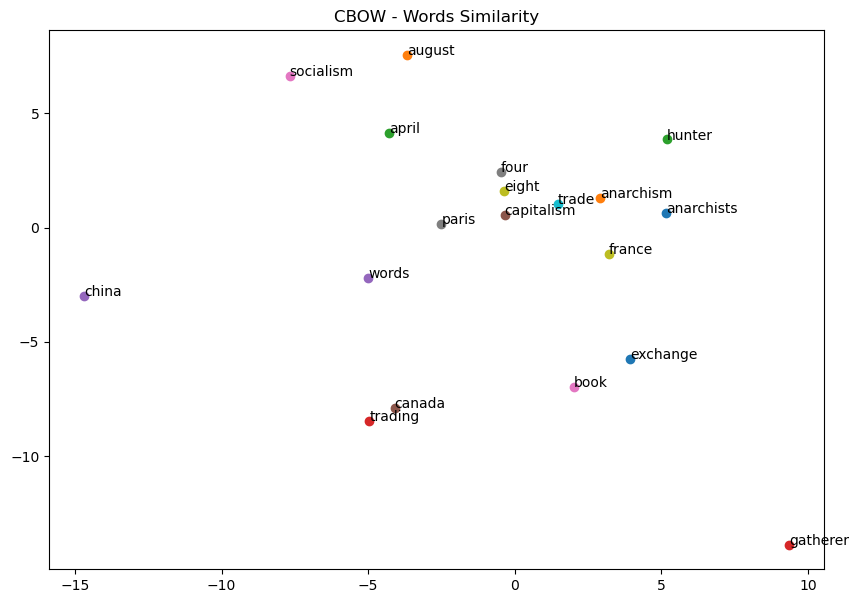

In [309]:
# test cbow
plot_words(words, 1)

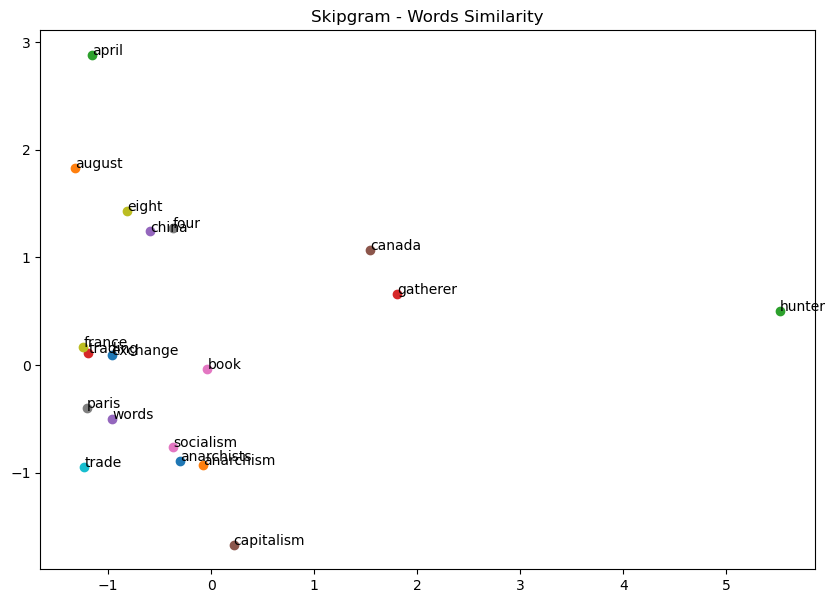

In [310]:
# test skipgram
plot_words(words, 0)

### Challenges

First and foremost challenge that was faced in implementation was computational resources to train the model. Initially, I started with 20,000 words to train CBOW and Skipgram, but time taken to train each epoch for Skipgram was extremely prolonged. To alleviate the resources constraint issue, I reduced the size of corpus to 10,000 tokens and therefore, time taken by each epoch relatively reduced.

Potential improvements that can further enhance the performance of these algorithms would be trying out different optimizers and loss functions. 

### Conclusion

Potential applications for CBOW model are:

1. Word Similarity and Analogies: CBOW embeddings can be used to evaluate how similar words are to capture their semantic relationships. 
2. Chatbots and Assistants: By capturing semantic relationship between words, embeddings can be used to generate relevant responses. 
3. Document clustering: Embeddings can be used to cluster similar documents based on their content just as how we saw in pubmed articles during one of our discussion week. 

Potential applications for Skip-gram model are:

1. Word Similarity and Analogies: Skip-gram embeddings can be used to evaluate how similar words are to capture their semantic relationships.
2. Chatbots and Assistants: By capturing semantic relationship between words, skip-gram embeddings can be used to generate relevant responses and this will improve system's conversational abilities. 
3. Sentiment Analysis: Embeddings can be used to understand emotional tone and sentiment of text which can improve emotional connotations for computer generated responses. 

In conclusion, for both CBOW and skip-gram, the aim is to create word embeddings that can represent contextual meaning of words in a continous vector space. 